<a href="https://colab.research.google.com/github/thanhetebkdn/modelAI/blob/main/Arrhythmia_on_ECG_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: browse through folders /content/drive/MyDrive/Project-EdgeAI/Dataset/ECG_Heartbeat_Categorization_Dataset

import os

# Path to the folder you want to browse
folder_path = '/content/drive/MyDrive/Project-EdgeAI/Dataset/ECG_Heartbeat_Categorization_Dataset'

# Check if the folder exists
if os.path.exists(folder_path):
  # Iterate through the files and folders in the directory
  for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    print(item_path)  # Print the path of each item
    if os.path.isdir(item_path):
      print("  (This is a directory)")  # Indicate if it's a directory
else:
  print(f"Folder '{folder_path}' not found.")

/content/drive/MyDrive/Project-EdgeAI/Dataset/ECG_Heartbeat_Categorization_Dataset/mitbih_test.csv
  (This is a directory)
/content/drive/MyDrive/Project-EdgeAI/Dataset/ECG_Heartbeat_Categorization_Dataset/Link to source.gdoc
/content/drive/MyDrive/Project-EdgeAI/Dataset/ECG_Heartbeat_Categorization_Dataset/ptbdb_normal.csv
  (This is a directory)
/content/drive/MyDrive/Project-EdgeAI/Dataset/ECG_Heartbeat_Categorization_Dataset/mitbih_train.csv
  (This is a directory)
/content/drive/MyDrive/Project-EdgeAI/Dataset/ECG_Heartbeat_Categorization_Dataset/ptbdb_abnormal.csv
  (This is a directory)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Project-EdgeAI/Dataset/ECG_Heartbeat_Categorization_Dataset')


In [ ]:
print(os.getcwd())

/content/drive/MyDrive/Project-EdgeAI/Dataset/ECG_Heartbeat_Categorization_Dataset


In [28]:
train_df = pd.read_csv('mitbih_train.csv', header=None)
test_df = pd.read_csv('mitbih_test.csv', header=None)


In [29]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)



187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


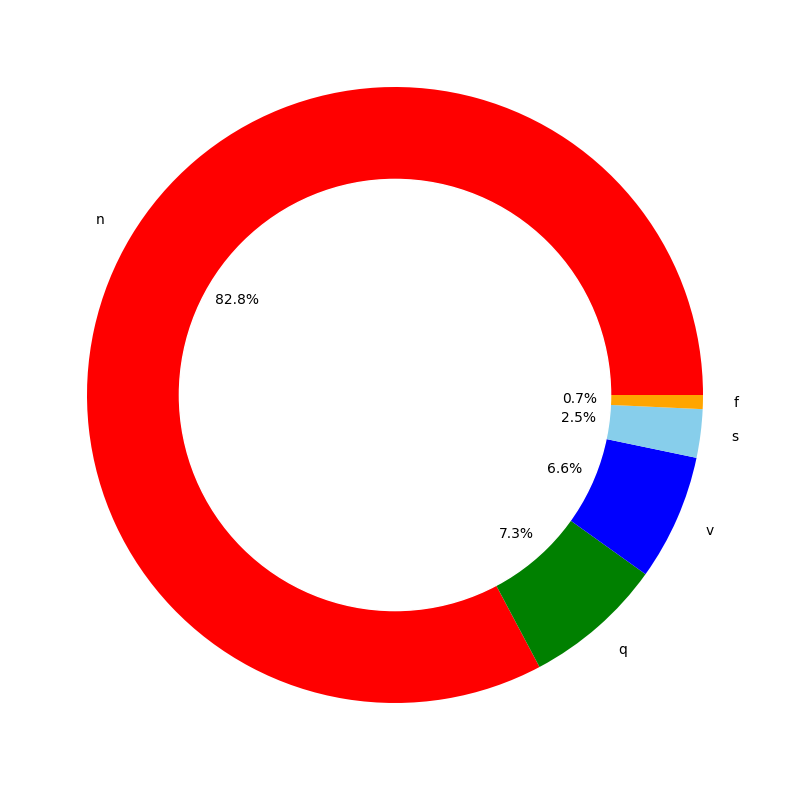

In [30]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

We can underligned a huge difference in the balanced of the classes. After some try i have decided to  choose the resample technique more than the class weights for the algorithms.

In [32]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [33]:
equilibre=train_df[187].value_counts()
print(equilibre)


187
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64


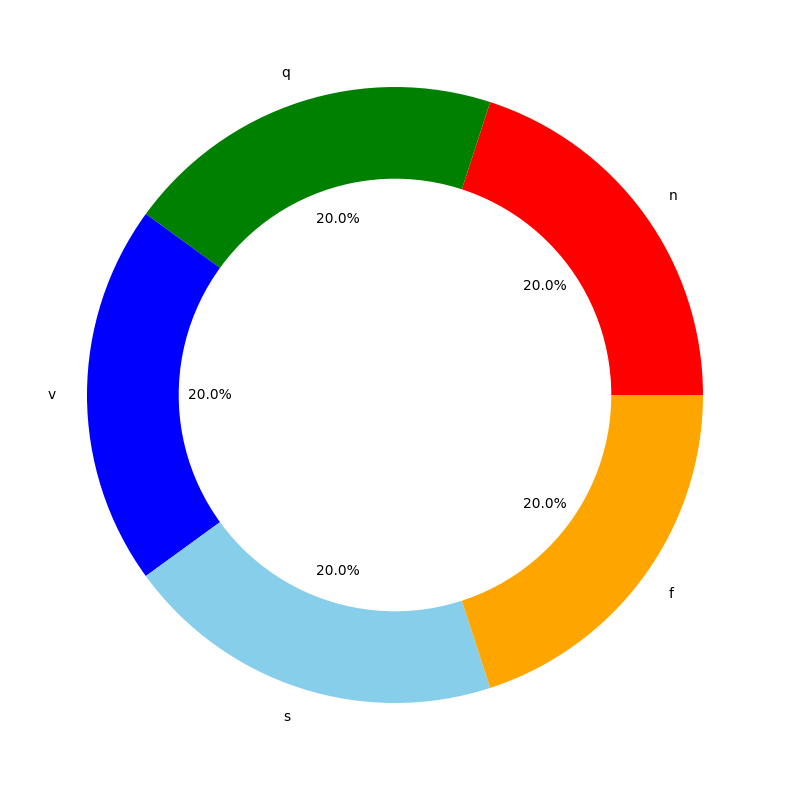

In [34]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

DataFrame mới, chứa ngẫu nhiên từ mỗi nhóm trong cột 187. mỗi nhóm có giá trị giống nhau trong cột này sẽ có một hàng duy nhất được chọn ngẫu nhiên

In [35]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [36]:
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
48100,0.949735,0.798942,0.182540,0.058201,0.066138,0.089947,0.074074,0.082011,0.066138,0.087302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73648,1.000000,0.860360,0.297297,0.072072,0.076577,0.148649,0.166667,0.171171,0.261261,0.220721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
78839,0.002415,0.000000,0.043478,0.132850,0.210145,0.276570,0.375604,0.434783,0.479469,0.574879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80800,1.000000,0.887344,0.668985,0.381085,0.123783,0.097357,0.101530,0.075104,0.066759,0.048679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
84046,1.000000,0.462963,0.511111,0.511111,0.522222,0.503704,0.518519,0.459259,0.362963,0.214815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


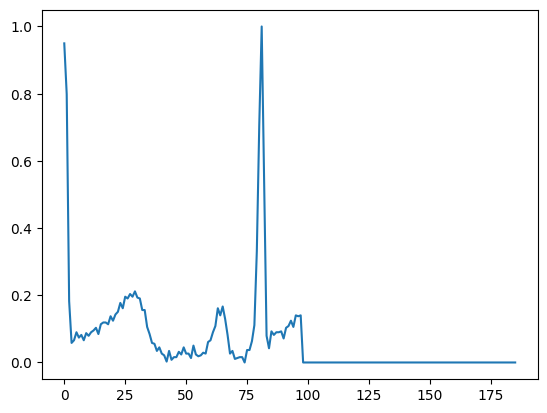

In [37]:
 plt.plot(c.iloc[0,:186])

Đây là nhịp tim bình thường

In [38]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


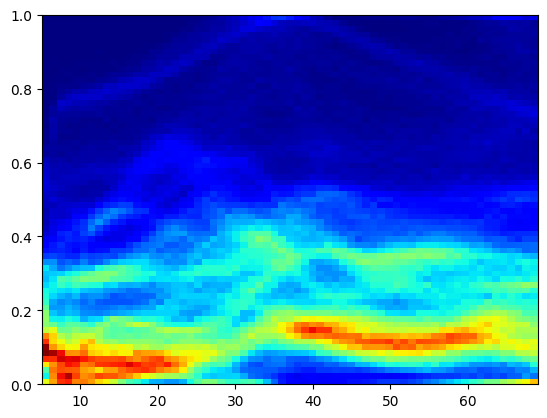

In [39]:
plot_hist(0,70,5,65)

Đây là hình đại diện cho cả lớp. Chúng tôi lấy tất cả tín hiệu và lập bản đồ chúng. Như vậy chúng ta có thể ước tính được tín hiệu sẽ trông như thế nào.

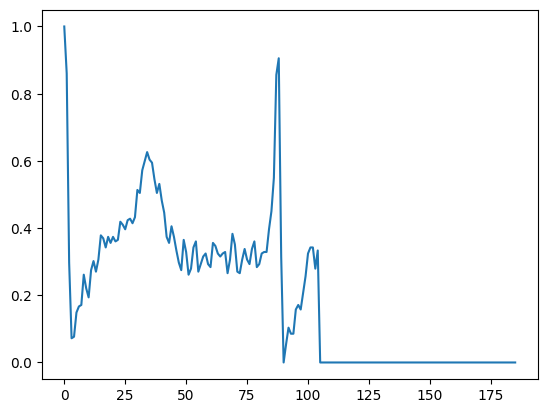

In [40]:
 plt.plot(c.iloc[1,:186])

900000
900000


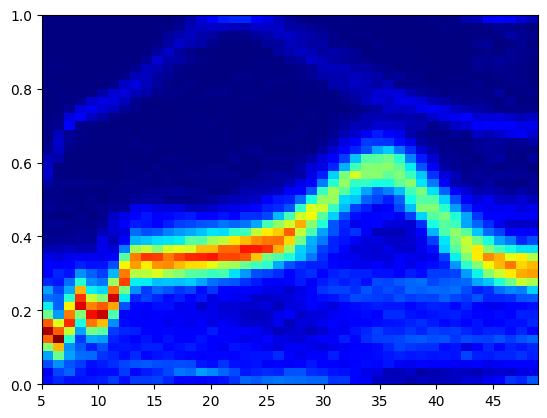

In [41]:
plot_hist(1,50,5,45)

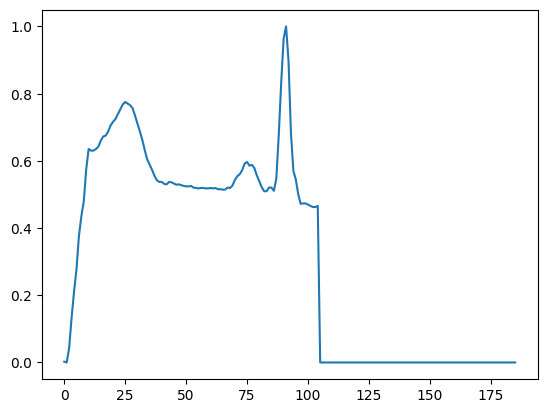

In [42]:
 plt.plot(c.iloc[2,:186])

900000
900000


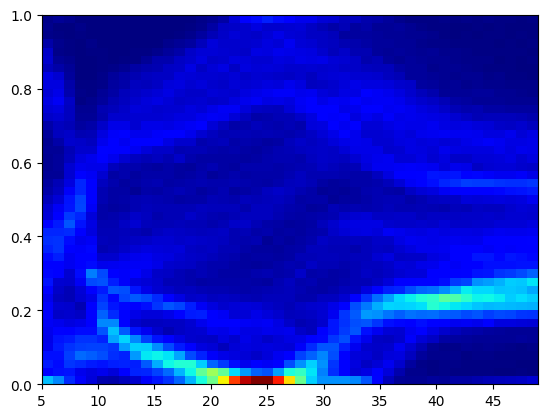

In [43]:
plot_hist(2,50,5,45)

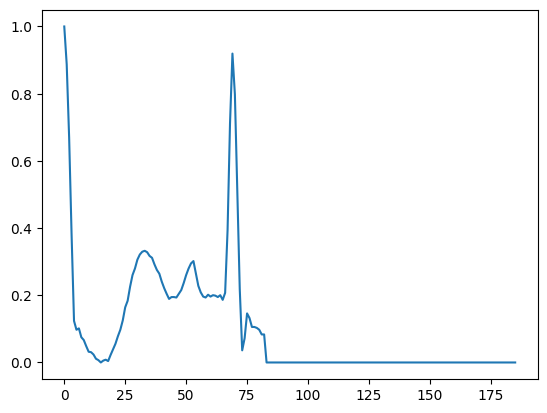

In [44]:
plt.plot(c.iloc[3,:186])

900000
900000


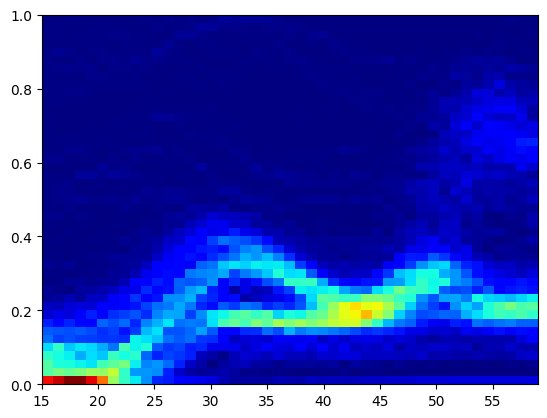

In [45]:
plot_hist(3,60,15,45)

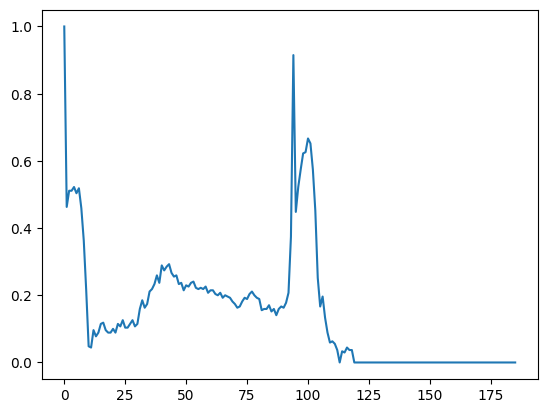

In [46]:
plt.plot(c.iloc[4,:186])

700000
700000


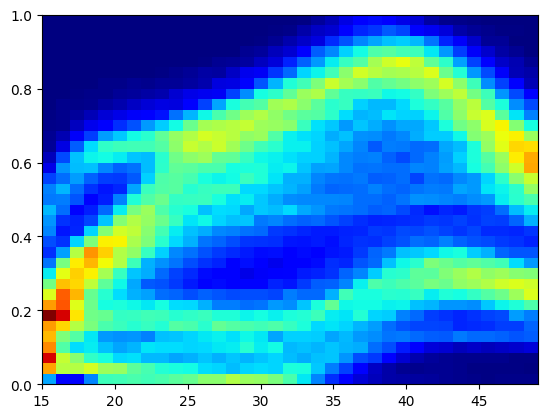

In [47]:
plot_hist(4,50,15,35)

Trong phần này tôi sẽ nói về những gì tôi làm để chuyển đổi dữ liệu.

In [48]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)


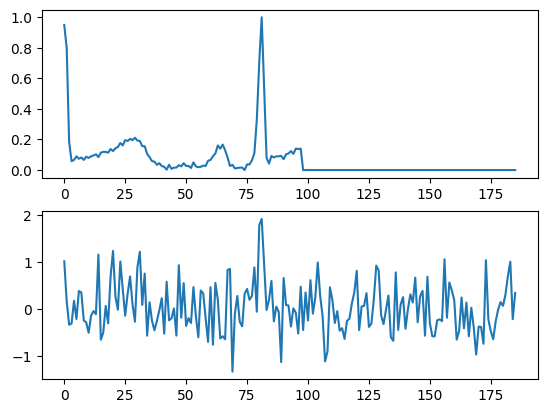

In [49]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()



In [50]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [51]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [52]:
def network(X_train,y_train,X_test,y_test):


    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])


    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [53]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)


In [74]:
pip install keras-layer-normalization

  Preparing metadata (setup.py) ... done
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4654 sha256=f54b8c2b4e5d271e8baa07e6e6008d37862dfe34da9e2e8f55dc154c11c55dd8
  Stored in directory: /root/.cache/pip/wheels/ed/3a/4b/21db23c0cc56c4b219616e181f258eb7c57d36cc5d056fae9a
Successfully built keras-layer-normalization


In [75]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)



ModuleNotFoundError: No module named 'keras.layers.normalization'

In [ ]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

